<a href="https://colab.research.google.com/github/talbenha/urban-sound-classification/blob/main/final_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction to Deep Learning - Final Project

## **Urban Sounds classification to detect gunshots**

**Introduction**: 
These days, the widespread use of illegal weapons is a worrying aspect of Israeli society. Therefore, we suggest a project that identifies gunshots in urban environments. This detection could help in direct Direction Of Arrival (DOA) estimation. 

In this project, we performed an Urban Sounds classification to detect gunshots. We used a variety of principles related to signal processing to create the spectrogram and the data we will work with, to achieve good results. 

We Decided to implement CNN model to perform the classification, after comparison to other ways. In this project, with our model, we achieve above 99% accuracy !! We will present during the project several ways we have worked with.

Our project is built step by step (each step is detailed during the work):
- Organization of the data we work with
- Split the data to train, validation and test sets
- Naive model 
- Sound Analysis and Spectrograms
- CNN model
- Multi-label classification
- Multi-Class + Augmentation
- Binary Classification
- Binary Classification + Augmentation
- Blending sounds
- Comparison to non-deep learning methods: logistic regression, Decision Tree Classifier
- Result analysis and Conclusion

Hope you will find this project interesting!

In [ ]:
import os
import sys

import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torchvision.transforms as T

import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import cv2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from PIL import Image

import time
import librosa
import librosa.display
from tqdm.notebook import tqdm


Seed Everything - necessary for reproducation. seed helps get predictable, repeatable results every time. If we do not set the seed, then we get different random numbers at every invocation. Setting the seed to some value, say 0 or 123 will generate the same random numbers during multiple executions of the code on the same machine or different machines

In [ ]:
# Seed
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [ ]:
# Your device is
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'your device is {device}⚙️ - this should be cuda')

your device is cuda⚙️ - this should be cuda


# check GPU

In [ ]:
!nvidia-smi -L
!nvidia-smi

GPU 0: Tesla T4 (UUID: GPU-72efcfcb-94c0-4feb-9e8e-b9a7f2dacb25)
Sun Feb 13 12:41:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    32W /  70W |   3192MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                       

## **Our data:**

8732 audio files of urban sounds in WAV format

**classID:**

A numeric identifier of the sound class:

0 = air_conditioner

1 = car_horn

2 = children_playing

3 = dog_bark

4 = drilling

5 = engine_idling

6 = gun_shot

7 = jackhammer

8 = siren

9 = street_music

In [ ]:
class_ord={0:'air_conditioner', 
           1:'car_horn',
           2:'children_playing',
           3:'dog_bark',
           4:'drilling',
           5:'engine_idling', 
           6:'gun_shot', 
           7:'jackhammer', 
           8:'siren',
           9:'street_music'}

class_binary={0:'not_gun_shot', 1:'gun_shot'} # binary classification

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
base_path = '/content/gdrive/My Drive/Intro_to_Deep_Learning/project/' # project/data/UrbanSound8K/metadata
print(os.listdir(base_path))
csv_path = os.path.join(base_path, 'UrbanSound8K.csv')
df = pd.read_csv(csv_path)
df

['final_notebook.ipynb', 'UrbanSound8K.csv', 'data', 'Tal_work_project.ipynb', 'best_model_mixed_aug_False_binaryClassification_False.pt', 'UrbanSound8K_train.csv', 'UrbanSound8K_valid.csv', 'UrbanSound8K_test.csv', 'final_notebook_old.ipynb']


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


# Explaination about the presented columns:
1. **fsID:** The Freesound ID of the recording from which this excerpt (slice) is taken
2. **start:** The start time of the slice in the original Freesound recording
3. **end:** The end time of slice in the original Freesound recording
4. **salience:** A (subjective) salience rating of the sound. 1 = foreground, 2 = background.
5. **fold:** The fold number (1-10) to which this file has been allocated.



# **Split the data to train, validation and test sets.**
We split our data to train,validation and test - since we saw that the data is imblanced (meaning each class has very different number of examples), we are using the default stratified splitting to preserve the ratio of each class in the training and test as well. Then we use MLP model to classify between the different classes.

In [ ]:
df_train, df_test= train_test_split(df, test_size=0.2, shuffle=True, random_state=seed)
df_train, df_valid= train_test_split(df_train, test_size=0.25, shuffle=True, random_state=seed)


#sanity check of the datasets size
print(f"Ratios:")
print(f"Train size:{df_train.shape[0]/df.shape[0]:.03}")
print(f"Validation size:{df_valid.shape[0]/df.shape[0]:.03}")
print(f"Test size:{df_test.shape[0]/df.shape[0]:.03}")

#Sanity check that the classes are distributied similar
for curr_df, data_str in zip([df_train, df_valid, df_test], ['train', 'valid', 'test']):
  labels = curr_df.classID.values
  dict_classes = {i: 100*round((np.array(labels) == i).sum()/len(labels), 2) for i in range(10)}
  print(f"{data_str}: {dict_classes}")

#reset the index to the appropriate range
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Save the 3 dataframes
df_train.to_csv(os.path.join(base_path, 'UrbanSound8K_train.csv'))
df_valid.to_csv(os.path.join(base_path, 'UrbanSound8K_valid.csv'))
df_test.to_csv(os.path.join(base_path, 'UrbanSound8K_test.csv'))

Ratios:
Train size:0.6
Validation size:0.2
Test size:0.2
train: {0: 12.0, 1: 5.0, 2: 11.0, 3: 11.0, 4: 12.0, 5: 11.0, 6: 4.0, 7: 12.0, 8: 11.0, 9: 11.0}
valid: {0: 11.0, 1: 5.0, 2: 12.0, 3: 11.0, 4: 11.0, 5: 12.0, 6: 5.0, 7: 11.0, 8: 11.0, 9: 12.0}
test: {0: 11.0, 1: 5.0, 2: 12.0, 3: 12.0, 4: 11.0, 5: 12.0, 6: 5.0, 7: 11.0, 8: 11.0, 9: 12.0}


# Let's visualize the distribution of the classes using pie and histogram

The number of samples in the training data is 5238


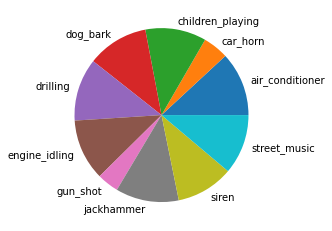

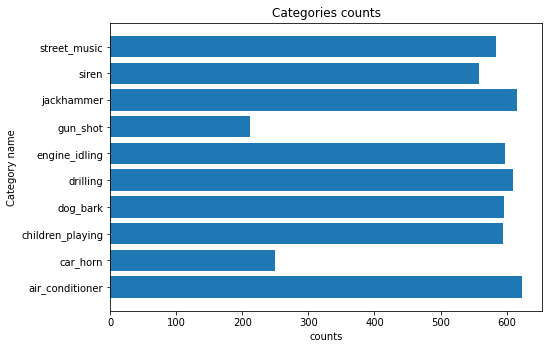

In [ ]:
classes, counts = np.unique(df_train['class'], return_counts=True)
print(f"The number of samples in the training data is {df_train.shape[0]}")
plt.figure()
plt.pie(counts, labels = classes)
plt.show()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.barh(classes, counts)
plt.title('Categories counts'), plt.xlabel('counts'), plt.ylabel('Category name')
plt.show()


# Loading the RAW sound data 
Using several functions - 

1.   The first function is used for one file loading
2.   The second function insert each sound file into the list, we also save the corresponding class label for each sound signal
3.   Function that takes the sound training data and changes all the samples to the same length (using the maximum length) - Since the raw signals contain samples in an arbitrary length, we want to create a unified length for all. This is a challenge that came up in our project, that we solved by zeros padding of the audio files.
4.   Function that takes the sound validation/test data and changes all the samples to the same length as the training length
5. Load all the data and create a unified matrix to each type (train/valid/test) using other functions - the shape of this matrix is [#samples, signals length]- this file is saved in our drive
6. Once the files have been created - we can load them using the last function for the several models and function to evaluate the model on the test dataset:



In [ ]:
def load_file(filename): 
    """
    loading one file by the corresponding path
    """
    try:
        x, _ =librosa.load(filename, res_type='kaiser_fast')
        del filename
    except:
        return None, None
    return x

def load_data(root_dir, folders, file_names, class_id, err_file='UNSUCCESSFUL_LOAD.txt'):
    """
    loading all files to one list (data) contains all signals' np.arrary
    """
    data=[]
    lbl=[]
    num=len(file_names)
    p_bar = tqdm(range(num))
    if len(folders)==len(file_names):
        for i in p_bar:
            file_path = os.path.join(root_dir,
                                     'fold{}'.format(folders[i]),
                                     file_names[i])
            x=load_file(file_path)
            if x is not None:
                data.append(x)
                lbl.append(class_id[i])
            else:
                print('Unabled to load file -> '+file_path+'\n')
    else:
        print('Error: Unequal Length')
    del root_dir, folders, file_names, class_id, err_file, num, file_path, x
    return data, lbl

def data2straight(data):
  all_lens = []
  for d in data:
    all_lens.append(len(d))
  max_samples = max(all_lens) # taking maximum for max length
  straight_data = []
  for d in data:
    curr_data = np.zeros(max_samples)
    curr_data[:len(d)] = d
    straight_data.append(curr_data[None])
  
  straight_data = np.concatenate(straight_data, axis=0)
  return straight_data, max_samples

def data2cut(data, train_max_samples):
  all_lens = []
  for d in data:
    all_lens.append(len(d))
  max_samples = max(all_lens) # taking maximum for max length
  if train_max_samples > max_samples:
    max_samples = train_max_samples
  straight_data = []
  for d in data:
    curr_data = np.zeros(max_samples)
    curr_data[:len(d)] = d
    straight_data.append(curr_data[None])
  
  straight_data = np.concatenate(straight_data, axis=0)
  if train_max_samples < max_samples:
    data_new = np.zeros(straight_data.shape[0], train_max_samples)
    data_new = straight_data[:,:train_max_samples]
    straight_data = data_new
  
  return straight_data

def create_np_data_file(data_type_str, curr_df, root_dir):
  # Extract the columns
  file_names = curr_df.slice_file_name
  folders = curr_df.fold
  class_id = curr_df.classID
  # Create file path string for the signal and label 
  np_dir = os.path.join(base_path, f'data/{data_type_str}_raw_data.npy')
  labels_dir = os.path.join(base_path, f'data/{data_type_str}_labels_data.npy')
  len_max_dir = os.path.join(base_path, f'data/train_len_max.npy')

  if not(os.path.isfile(np_dir) and os.path.isfile(labels_dir)):
    data, labels = load_data(root_dir=root_dir, folders=folders, file_names=file_names, class_id=class_id)
    if data_type_str == 'train':
      data, max_samples = data2straight(data)
      np.save(len_max_dir, [max_samples], allow_pickle=True)
    else:
      max_samples = np.load(len_max_dir, allow_pickle=True)[0]
      data = data2cut(data, max_samples)

    np.save(np_dir, data, allow_pickle=True)
    np.save(labels_dir, labels, allow_pickle=True)

    print('Total Files:',len(file_names))
    print('Successful:',len(data))
    print('Unsuccessful:', len(file_names)-len(data))

  else:
    print('already created')

def load_data_file(data_type_str, curr_df, root_dir):
  file_names = curr_df.slice_file_name
  # Create file path string for the signal and label 
  np_dir = os.path.join(base_path, f'data/{data_type_str}_raw_data.npy')
  labels_dir = os.path.join(base_path, f'data/{data_type_str}_labels_data.npy')
  len_max_dir = os.path.join(base_path, f'data/train_len_max.npy')
  
  data, labels = np.load(np_dir, allow_pickle=True), np.load(labels_dir, allow_pickle=True)

  print('Total Files:',len(file_names))
  print('Successful:',len(data))
  print('Unsuccessful:', len(file_names)-len(data))
  return data, labels
  

# Now, we load all the training, validation and test audio sounds. 
If the files have not already created - we create them and then load it.

In [ ]:
root_dir=os.path.join(base_path, 'data/UrbanSound8K/audio')

for curr_df, data_str in zip([df_train, df_valid, df_test], ['train', 'valid', 'test']):
  create_np_data_file(data_str, curr_df, root_dir)
  print()

all_ds = []
all_lbls = []
for curr_df, data_str in zip([df_train, df_valid, df_test], ['train', 'valid', 'test']):
  data, labels = load_data_file(data_str, curr_df, root_dir)
  all_ds.append(data), all_lbls.append(labels)
  print()
train_data, valid_data, test_data = all_ds
train_labels, valid_labels, test_labels = all_lbls 
print(f"Data Shapes: train: {train_data.shape}, valid: {valid_data.shape}, test: {test_data.shape}")
print(f"Labels Shapes: train: {train_labels.shape}, valid: {valid_labels.shape}, test: {test_labels.shape}")

already created

already created

already created

Total Files: 5238
Successful: 5238
Unsuccessful: 0

Total Files: 1747
Successful: 1747
Unsuccessful: 0

Total Files: 1747
Successful: 1747
Unsuccessful: 0

Data Shapes: train: (5238, 89009), valid: (1747, 89009), test: (1747, 89009)
Labels Shapes: train: (5238,), valid: (1747,), test: (1747,)


We can observe that all the signal are at the same length!

# Let's present 10 signals- each correpsonds to the unique class 


Note that these are the signals after zeros pedding

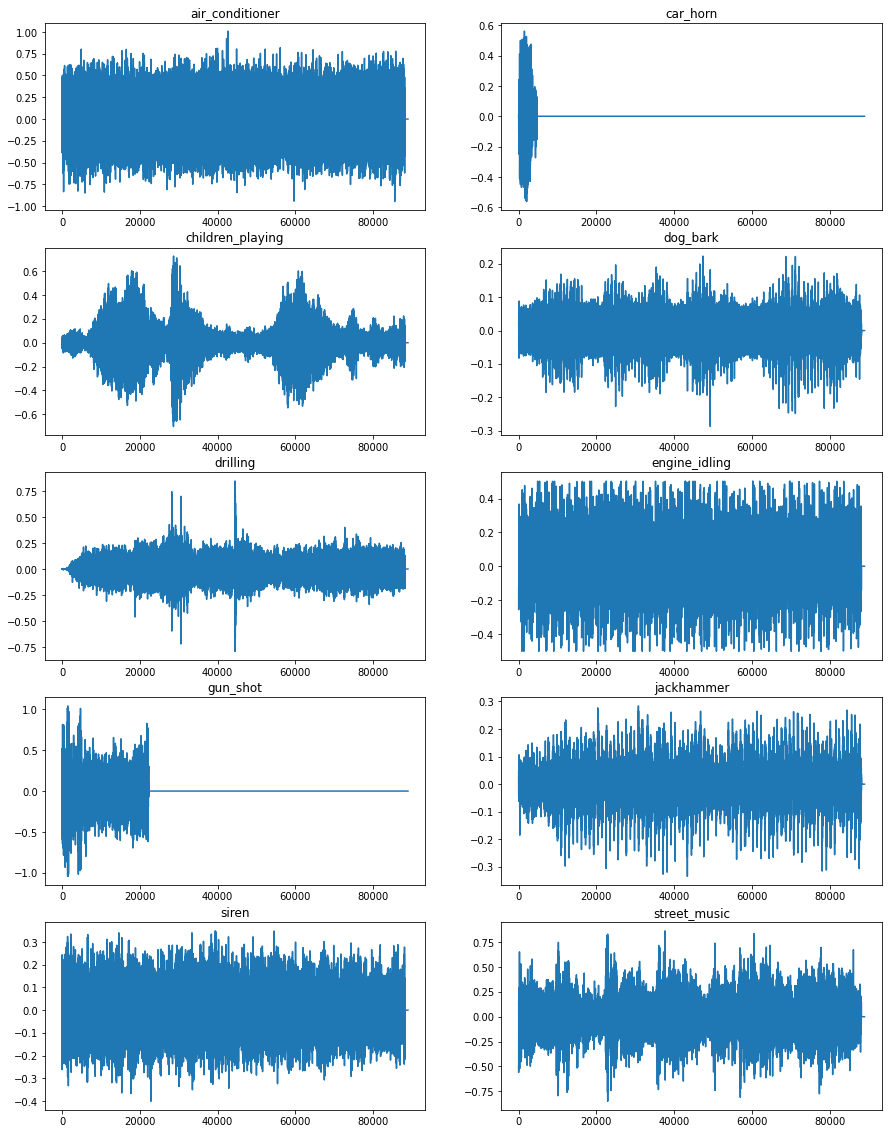

In [ ]:
f, ax=plt.subplots(nrows=5, ncols=2, figsize=(15,20))
ind=0
for row in ax:
    for col in row:
        col.title.set_text(class_ord[ind])
        col.plot(train_data[train_labels.tolist().index(ind)])    
        ind+=1

# Naive model
First, we want to check the naive solution - use the sound signals as input to our model without pre-processing or feature extraction. We can do so since we have a signal in the same length (one of the reasons for previous code cell operation).
This step is required since it can help us understand if the raw signals capture relevant information that can use for the learning model.   

Converting the lists to PyTorch tensor and create dataset theat we will use later in the training.

In [ ]:
tensor_x = torch.Tensor(train_data)# transform to torch tensor
# tensor_x.to(device) 
tensor_y = torch.Tensor(train_labels)
# tensor_y.to(device)
my_dataset = TensorDataset(tensor_x, tensor_y) # create your datset

In [ ]:
# del train_data, train_labels
tensor_x_valid = torch.Tensor(valid_data) # transform to torch tensor
# tensor_x_valid.to(device) 
tensor_y_valid = torch.Tensor(valid_labels)
# tensor_y_valid.to(device) 
del valid_data, valid_labels

# Model, Training and Evaluation
Now, we create the MLP class with three linear layers, the first two layers are followed by *RELU* activation function for non-linearity. The last layer is activation-free since in the loss function (which is the cross-entropy) a ***softmax*** operation is applied to the output for obtaining probability for each class.

Illustrate the structure of the MLP (When in our case there are 3 linear layers): 

<img src= 'https://static.packt-cdn.com/products/9781786468574/graphics/B05474_04_05.jpg'>

We also create a custom function for training and evaluation. The evaluation function returns the accuracy measure given the data, labels, and the network to perform prediction. The training function takes as input the optimizer, the loss function(criterion), the network model, train_dataset (to generate data loader), the number of training epochs, and the batch size. 

Batch size: The number of examples from the training dataset used in the estimate of the error gradient. We may want to use a larger batch size to train our model as it allows computational speedups, but we know that too large of a batch size will lead to poor generalization, We saw that
with a batch size of ~60 we got great accuracy! 

The training function performs training and returns the trained network as well as the training/validation loss and accuracy per iteration.

In [ ]:
class FC_Model(nn.Module):
    def __init__(self, input_shape, l_size1, l_size2, classes=10):
        super(FC_Model, self).__init__()
        self.fc1 = nn.Linear(input_shape, l_size1)
        self.fc2 = nn.Linear(l_size1, l_size2)
        self.fc3 = nn.Linear(l_size2, classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def eval(net, x, y):
  size_curr = len(x)
  pred = net(x).argmax(dim=-1).squeeze()
  accuracy = (pred == y).sum() / size_curr
  return accuracy

def training_func(optimizer, criterion, net, train_dataset, epochs, batch_size: int = 60):
  dataloader = DataLoader(train_dataset, batch_size=batch_size)
  # n_loops = len(dataloader)
  p_bar = tqdm(range(epochs))
  erros_iter = []
  loss_tr = []
  loss_val = []
  accuracy_val = []
  accuracy_train = []
  for i in p_bar:
    for batch in dataloader:
      x, labels = batch

      #optimization step
      optimizer.zero_grad()
      predicted = net(x).squeeze()
      loss = criterion(predicted, labels.long())
      loss.backward()
      optimizer.step()
    
    loss_tr.append(loss.detach().cpu())
    loss_val.append(criterion(net(tensor_x_valid).squeeze(), tensor_y_valid.long()))
    accuracy_val.append(eval(net, tensor_x_valid, tensor_y_valid))
    accuracy_train.append(eval(net, tensor_x, tensor_y))

    p_bar.set_description(f'loss={loss.detach().cpu():.03}, accuracy_train={accuracy_train[-1]:.03}, accuracy_val={accuracy_val[-1]:.03}')
  return net, loss_tr,loss_val, accuracy_val, accuracy_train

criterion = nn.CrossEntropyLoss()
model = FC_Model(tensor_x[0].shape[-1], 128, 32, 10)
optimizer  = torch.optim.Adam(model.parameters())
trained_net, loss_tr,loss_val, accuracy_val, accuracy_train = training_func(optimizer, criterion, model, my_dataset, epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

**Now, we present the accuracy and the loss functions during the training epochs:**

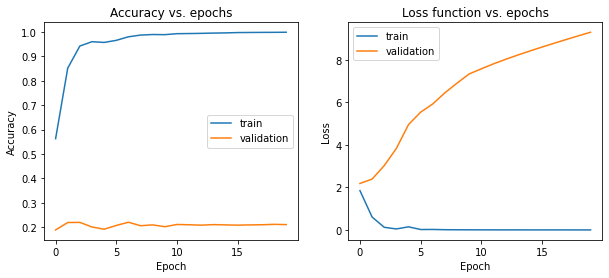

In [ ]:
f, ax=plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ax[0].title.set_text("Accuracy vs. epochs")
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].plot(accuracy_train)
ax[0].plot(accuracy_val)
ax[0].legend(['train', 'validation'])

ax[1].title.set_text("Loss function vs. epochs")
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].plot(loss_tr)
ax[1].plot(loss_val)
ax[1].legend(['train', 'validation'])
plt.show()

As observed from the graphs our model is highly overfitted. We can conclude that this approach to using a naive model is wrong. The model "remembers" the training examples and does not generalize well on unseen data. With this conclusion in our mind, we will try a different approach.

# Sound Analysis and Spectograms 


In this project, our main goal is to identify gunshots from Urban Sounds. First, we will make a brief overview of gunshot sounds in terms of signal processing:

**Some facts we considered during gunshot sound signal processing:**

1.	Time Domain: A typical gunshot signal is impulsive and consists mostly of two characteristic waves: the muzzle blast and the shockwave. The first component is a consequence of the explosion of the charge in the gun barrel, lasts 3–5 ms, and propagates through the air at the speed of sound. The latter is due to the dispersion of air molecules caused by the motion of the projectile when traveling at supersonic speed. As the bullet travels, the shockwave expands as a cone behind it and its wavefront propagates at the speed of sound. The shock wave component lasts 0.3–0.5 ms.
2.	Frequency Domain: most of the energy of a gun hot signal is in low frequencies between 150 Hz to 1.5 kHz. 
3.	We only need to detect the signals, considerations like sound signal quality are irrelevant.
4.	Our information set is not sampled at a uniform rate and ranges from one to three seconds.

The signal processing steps:
1.	Sampling the signals at a uniform rate, a low rate is selected relative to the signals in the data set.
2.	Pad the signals with zeros to ~four seconds in length (to the maximum length).
3.	From the first two facts, we conclude that the STFT transform is the natural transform for solving the problem. It contains information both in the time and frequency domain. In addition, it helps us to convert the problem from voice signal classification to image classification. That type of problem has been extensively researched in the academic world and industry.
4.	Because of the wide range of acoustic signal amplitude, we prefer to convert its STFT values to dB.
5.	From the third fact, we understand it logically to apply an aggressive noise filter, as nullifying low energy.
6.	Because of the second fact, we strive to focus the image around 1k Hz. We can do it by logarithmic scale or MEL scale (a scale of pitches judged by listeners to be equal in distance one from another). 

In the previous approach, we have used the time-domain only. We want to integrate also frequency domain information that will be used as input to our model, and to gain the advantages of both worlds (time and frequency) as we mentioned before. Therefore, we use a spectrogram which is a time-frequency representation. As the spectrogram present both, the time and the frequency, we get a 2D matrix which can be interpreted as an image also. This intuition is leading us to use the Convolution Neural Network (CNN) model which is highly suited for vision tasks (as learned in the lectures) to capture the information of the spectrogram.

**Note:** Since google collab provides limited hardware sources (i.e. GPU and RAM), we are using resize operation (from the OpenCV package) to downsample the image to a fixed and lower size that can feet to the sources provided.  

In [ ]:
def create_spectrogram(signal, sample_rate, save_path, required_shape):
    stft = np.abs(librosa.stft(signal.squeeze()))**2
    spec = librosa.feature.melspectrogram(S=stft, sr=sample_rate)
    spec_dB = librosa.power_to_db(spec, ref=np.max)
    down_spec = cv2.resize(spec_dB, dsize=required_shape, interpolation=cv2.INTER_LINEAR)
    shape_spec = down_spec.shape
   # print(shape_spec)
    assert shape_spec[0] == required_shape[0] and shape_spec[1] == required_shape[1], f"problematic shape {shape_spec}, should be {required_shape}. Please check it"
    np.save(save_path, down_spec, allow_pickle=True)
    del signal, sample_rate, save_path, required_shape, stft, spec, spec_dB, shape_spec

def create_spectrogram_all(data, labels, class_ord, resolution, parent_dir='images', sample_rate=22050):

    os.makedirs(parent_dir, exist_ok=True) # create the parent directory
    # os.makedirs(os.path.join(parent_dir, 'meta_data'), exist_ok=True) # create the meta data directory
    for k,v in class_ord.items():
      os.makedirs(os.path.join(parent_dir, v), exist_ok=True) # create classes folders directory

    class_count=[0]*len(class_ord)
    p_bar = tqdm(range(len(labels)))
    dataframe = pd.DataFrame(columns=['file_path', 'class'])

    for index, signal, label in zip(p_bar, data, labels):
        class_count[label]+=1
        file_name = str(class_count[label]) + '.npy'
        save_path = os.path.join(parent_dir, class_ord[label], file_name)
        dataframe.loc[index] = [save_path, label]
        create_spectrogram(signal, sample_rate, save_path, required_shape=resolution)
    
    dataframe.to_csv(os.path.join(parent_dir, 'spectrogram_images.csv'), index=False)
    del data, labels, class_ord, parent_dir, sample_rate, class_count,p_bar, dataframe, index, signal, label, file_name, save_path

In [ ]:
resolution = (64,64)
parent_dir=os.path.join(base_path, f'data/image_data_low_res_{resolution[0]}')
for curr_data, curr_lbl, str_data_type in zip(all_ds, all_lbls, ['train', 'valid', 'test']):
  curr_path = os.path.join(parent_dir, str_data_type)
  if not os.path.isdir(curr_path):
    create_spectrogram_all(curr_data, curr_lbl, class_ord, resolution=resolution, parent_dir=curr_path)
  else:
    print(f'path: {curr_path}\n Already Exist!' )

path: /content/gdrive/My Drive/Intro_to_Deep_Learning/project/data/image_data_low_res_64/train
 Already Exist!
path: /content/gdrive/My Drive/Intro_to_Deep_Learning/project/data/image_data_low_res_64/valid
 Already Exist!
path: /content/gdrive/My Drive/Intro_to_Deep_Learning/project/data/image_data_low_res_64/test
 Already Exist!


# Plot the spectograms

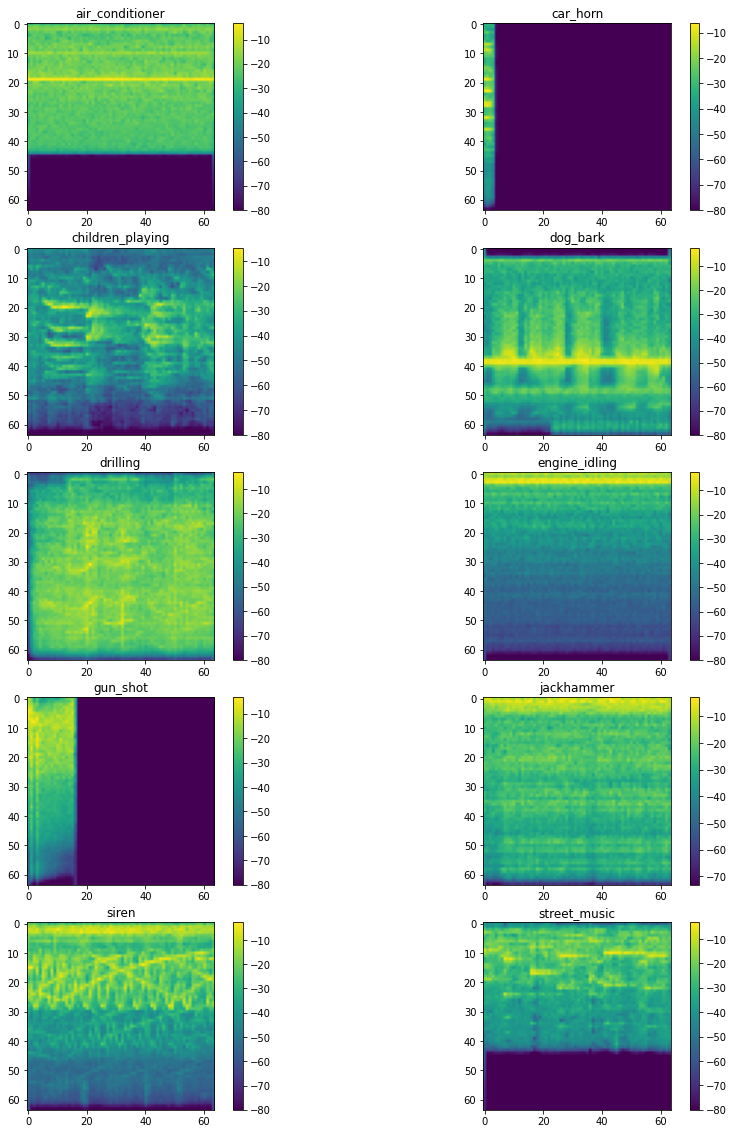

In [ ]:
f, ax=plt.subplots(nrows=5, ncols=2, figsize=(15,20))
ind=0
for row in ax:
  for col in row:
    curr_dir = os.path.join(base_path, f'data/image_data_low_res_{resolution[0]}', 'train', class_ord[ind], '1.npy')
    image = np.load(curr_dir, allow_pickle=True)
    col.title.set_text(class_ord[ind])
    pcm = col.imshow(image)
    f.colorbar(pcm, ax=col)  
    ind+=1

# **Dataset classes**

The first dataset is called CustomDataset. It loads the spectrograms and can apply augmentation and change the label to binary option - gunshot vs. non-gunshot. The non-binary option is the 10 classes classification. 

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, parent_dir, data_mode, class_ord=None, transform=False, binary=False):
      curr_path = os.path.join(parent_dir, data_mode, 'spectrogram_images.csv')
      df_all = pd.read_csv(curr_path)
      self.data_mode = data_mode
      self.df_info = df_all

      if transform:
          self.transform = T.RandomHorizontalFlip(p=0.5)
      else:
          self.transform = None
      self.binary = binary
      
      self.class_ord = class_ord if binary else None
      
      str_binary = 'binary' if binary else 'multi class'
      print(f'Succefull create *{data_mode}* dataset with {self.__len__()} items with {str_binary} mode')

    def __len__(self):
      return len(self.df_info)

    def __getitem__(self, idx):
      img_path = os.path.join(self.df_info.iloc[idx, 0])
      image = torch.from_numpy(np.load(img_path, allow_pickle=True)).float()
      # print(image.dtype)
      label = self.df_info.iloc[idx, 1]
      if self.binary:
          label = 1 if self.class_ord[label] == 'gun_shot' else 0
      if self.transform and self.data_mode == 'train':
          image = self.transform(image)
      return image[None], label

In [ ]:
# Sanity check
if os.path.exists(parent_dir):
  img_dataset = CustomDataset(parent_dir, data_mode='train')
else:
  assert False, "parent_dir directory does not exist, please check it!"

Succefull create *train* dataset with 5238 items with multi class mode


# Custom CNN model
We have created a custom CNN model which can be used for classification. It contains 2 parts:
1. The first part is composed of a convolutional filter, followed by RELU activation function and max-pooling operation.
2. Following the convolutional layers, the features are flattened to vector representation and fed forward to multilayer perceptrons (MLPs) layers. Each consists of a linear layer and RELU activation function.

CNN structure:

<img src= 'https://www.researchgate.net/publication/338199242/figure/fig1/AS:840889396113413@1577495063054/Basic-structure-of-a-CNN.jpg'>

Convolutional neural networks (CNN) are known to be good at image classification, but how can we use it on sound classification? The idea is to turn the samples into images, and for that one can use a spectrogram, as described in the 'Sound Analysis and Spectograms' part.

In [ ]:
class CNN_Model(nn.Module):
    def __init__(self, in_channels, filters, kernel_size, pooling,
                 fc_sizes, output_size, is_sigmoid=True):
      super().__init__()
      # treating the convolution layers
      self.convs = nn.ModuleList()
      self.pool = nn.MaxPool2d(pooling, stride=2)
      prev_n_filters = in_channels
      self.is_sigmoid = is_sigmoid
      for i in range(len(filters)):
        curr_n_filters = filters[i]
        conv = nn.Conv2d(prev_n_filters, curr_n_filters, kernel_size, padding=kernel_size//2) # in_channels, out_channels, kernel_size
        self.convs.append(conv)
        prev_n_filters = curr_n_filters

      
      # treating the mlp layers
      self.fcs = nn.ModuleList()
      self.drops = nn.ModuleList()
      for i in range(len(fc_sizes) - 1):
        curr_size1 = fc_sizes[i]
        curr_size2 = fc_sizes[i + 1]
        fc = nn.Linear(curr_size1, curr_size2)
        self.fcs.append(fc)
      fc = nn.Linear(curr_size2, output_size)
      self.fcs.append(fc)
      self.output_size = output_size
      
    def forward(self, x):
      # print(x.shape)
      for conv in self.convs: # conv layers
        # print(x.shape)
        x = self.pool(F.relu(conv(x)))
      # print(x.shape)
      x = torch.flatten(x, 1) # flatten all dimensions except batch
      # print(x.shape)
      for i in range(len(self.fcs) - 1): # fully connected layers
        x = F.relu(self.fcs[i](x))
      
      if self.output_size == 1 and self.is_sigmoid:
        sig = nn.Sigmoid()
        return sig(self.fcs[-1](x)) 
      
      return self.fcs[-1](x)

# We focus on training and evaluation now and create several functions:
The most important function is the training function- it takes the train and validation sets and performs training. We are using the validation set to calculate the accuracy per epoch. We save the best epoch model sate_dictionary which is the weights of the best model. 

We also have created a few functions for modular training and evaluation which will help to explore several models that will be detailed later.

In [ ]:
def eval_validation(valid_dataloader, net, criterion, binary, mix):
  temp_loss = []
  all_pred = []
  all_labels = []
  sum_correct = 0
  sum_shapes = 0
  for ind, batch in enumerate(valid_dataloader):
      x, labels = batch
      x, labels = x.to(device), labels.to(device)
      predicted = net(x).squeeze()
      if len(predicted.shape) != 1:
          if mix:
              loss = criterion(predicted, labels)
          else:
              loss = criterion(predicted, labels.long())
      else:
          loss = criterion(predicted, labels.to(torch.float32))

      temp_loss.append(loss.detach().cpu().numpy())
      if mix:
          correct, size_all, pred = correct_pred_mix(labels, predicted, binary)
      else:
          correct, size_all, pred = correct_pred(labels, predicted, binary)
      sum_correct += correct
      sum_shapes += size_all
      all_pred.append(pred)
      all_labels.append(labels)

  acc = sum_correct / sum_shapes

  return np.mean(temp_loss), acc, all_pred, all_labels


def correct_pred(labels, predicted, binary):
  with torch.no_grad():  # for accuracy
      if binary:
          pred = (predicted > 0.5).int()
      else:
          pred = predicted.argmax(dim=-1).squeeze()

  return (pred == labels).sum(), labels.shape[0], pred


def correct_pred_mix(labels, predicted, binary):
  with torch.no_grad():  # for accuracy
      if True:
          pred = (predicted > 0.5).int()
      else:
          pred = predicted.argmax(dim=-1).squeeze()
  total_num = 1
  for n in labels.shape:
      total_num *= n

  return (pred == labels).sum(), total_num, pred


def plot_con_mat(y_true, y_pred):
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
  plt.show()

def training_func(optimizer, criterion, net, train_dataset, valid_dataset, save_model_path, epochs=40,
                  batch_size: int = 64, binary=False, mix=False):
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
  valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)
  p_bar = tqdm(range(epochs))  # 
  erros_iter, loss_tr, loss_val, accuracy_val, accuracy_train = [], [], [], [], []
  best_acc = 0
  best_epoch = 0

  for curr_epoch in p_bar:
      sum_correct = 0
      sum_shapes = 0
      for idx_batch, batch in enumerate(train_dataloader):
          # print(idx_batch)
          x, labels = batch
          x, labels = x.to(device), labels.to(device)
          # optimization step
          optimizer.zero_grad()
          predicted = net(x).squeeze()
          # print(len(predicted.shape))
          if len(predicted.shape) != 1:
              if mix:
                  loss = criterion(predicted, labels)
              else:
                  loss = criterion(predicted, labels.long())
          else:
              loss = criterion(predicted, labels.to(torch.float32))

          loss.backward()
          optimizer.step()

          if mix:
              correct, size_all, pred = correct_pred_mix(labels, predicted, binary)
          else:
              correct, size_all, pred = correct_pred(labels, predicted, binary)
          sum_correct += correct
          sum_shapes += size_all

      with torch.no_grad():
          loss_tr.append(loss.detach().cpu())
          accuracy_train.append(sum_correct / sum_shapes)
          loss_mean, acc, all_pred, all_labels = eval_validation(valid_dataloader, net, criterion, binary, mix)
          loss_val.append(loss_mean)
          accuracy_val.append(acc)
        
      p_bar.set_description(f'loss={loss.detach().cpu():.03}, accuracy_train={accuracy_train[-1]:.03}, accuracy_val={accuracy_val[-1]:.03}')
      
      if accuracy_val[-1] > best_acc:
        best_acc = accuracy_val[-1]
        best_epoch = curr_epoch
        torch.save(net.state_dict(), save_model_path)
      elif (curr_epoch - best_epoch) == 5:
        print(f"We didn't improve 5 epoch, so finish the training... best epoch and accuracy are {best_epoch} and {best_acc}, respectively.")
        break
  
  net.load_state_dict(torch.load(save_model_path))
  net.eval()

  all_labels_np = torch.cat(all_labels).cpu().numpy()
  all_pred_np = torch.cat(all_pred).cpu().numpy()
  plot_con_mat(all_labels_np, all_pred_np)
  return net, loss_tr, loss_val, accuracy_train, accuracy_val


def plot_graphs(accuracy_train, accuracy_val, loss_tr, loss_val, title=''):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    fig.suptitle(title, fontsize=16)
    ax[0].title.set_text("Accuracy vs. epochs")
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].plot(accuracy_train)
    ax[0].plot(accuracy_val)
    ax[0].legend(['train', 'validation'])

    ax[1].title.set_text("Loss function vs. epochs")
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].plot(loss_tr)
    ax[1].plot(loss_val)
    ax[1].legend(['train', 'validation'])
    plt.show()

Function to evaluate the model on the test dataset:

In [ ]:
def run_multiOptions_training_Class(parent_dir, class_ord, transform, binary, epochs=20):
  exp_name = f'aug_{transform}_binaryClassification_{binary}'
  save_path = os.path.join(parent_dir, f'best_model_aug_{transform}_binaryClassification_{binary}.pt')
  
  criterion = nn.BCELoss() if binary else nn.CrossEntropyLoss()  
  
  output_size = 1 if binary else 10
  model = CNN_Model(in_channels=1, filters=[16, 16, 16, 32], kernel_size=3, pooling=2, fc_sizes=[512, 128], output_size=output_size)
  model = model.to(device)
  print(f"Validate that the model is on the GPU: {next(model.parameters()).is_cuda}")
  optimizer = torch.optim.Adam(model.parameters())
  train_dataset = CustomDataset(parent_dir=parent_dir, data_mode='train', class_ord=class_ord, transform=transform, binary=binary)
  valid_dataset = CustomDataset(parent_dir=parent_dir, data_mode='valid', class_ord=class_ord, transform=transform, binary=binary)
  trained_net, loss_tr, loss_val, accuracy_train, accuracy_val = training_func(optimizer, criterion, model, train_dataset, valid_dataset, save_path, epochs, binary=binary)
  plot_graphs(accuracy_train, accuracy_val, loss_tr, loss_val, title=exp_name)
  return trained_net, loss_tr, loss_val, accuracy_val, accuracy_train


def evaluate_on_test_data(trained_net, parent_dir, class_ord, transform, binary):
  exp_name = f'aug_{transform}_binaryClassification_{binary}'
  save_path = os.path.join(parent_dir, f'best_model_aug_{transform}_binaryClassification_{binary}.pt')

  criterion = nn.BCELoss() if binary else nn.CrossEntropyLoss()  

  if trained_net is None:
    output_size = 1 if binary else 10
    model = CNN_Model(in_channels=1, filters=[16, 16, 16, 32], kernel_size=3, pooling=2, fc_sizes=[512, 128], output_size=output_size)
    if os.path.isfile(save_path):
      model.load_state_dict(torch.load(save_path))
      trained_net = model
  trained_net = trained_net.to(device)
  trained_net.eval()
  print(f"Validate that the model is on the GPU: {next(trained_net.parameters()).is_cuda}")
  test_dataset = CustomDataset(parent_dir=parent_dir, data_mode='test', class_ord=class_ord, transform=transform, binary=binary)
  test_dataloader = DataLoader(test_dataset, batch_size=64, num_workers=2)
  loss_mean, acc, all_pred, all_labels = eval_validation(test_dataloader, trained_net, criterion, binary, mix=False)
  all_labels_np = torch.cat(all_labels).cpu().numpy()
  all_pred_np = torch.cat(all_pred).cpu().numpy()
  plot_con_mat(all_labels_np, all_pred_np)
  target_names=list(class_ord.values()) if not binary else ['not_gun_shot', 'gun_shot']
  print(target_names)
  print(classification_report(all_labels_np, all_pred_np, target_names=target_names))

# **Multi label classification**

First, let's perform regular multi-class classification. Meaning we classify each sample into one of the ten classes. We don't perform data augmentation (transform=False)

Validate that the model is on the GPU: False
Succefull create *train* dataset with 5238 items
Succefull create *valid* dataset with 1747 items


  0%|          | 0/20 [00:00<?, ?it/s]

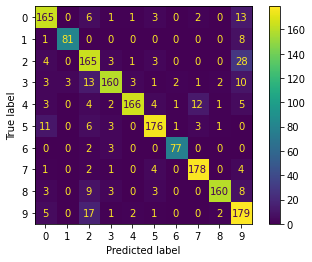

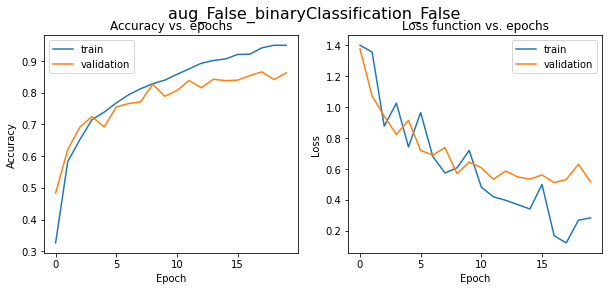

In [ ]:
trained_net, loss_tr, loss_val, accuracy_val, accuracy_train = run_multiOptions_training_Class(parent_dir, class_ord, transform=False, binary=False)

Now we explore the performences on the test dataset 

Validate that the model is on the GPU: True
Succefull create *test* dataset with 1747 items


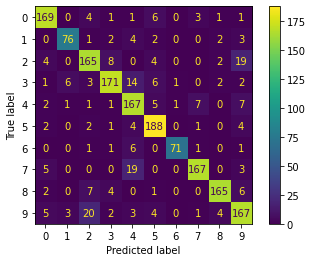

                  precision    recall  f1-score   support

 air_conditioner       0.89      0.91      0.90       186
        car_horn       0.88      0.84      0.86        90
children_playing       0.81      0.82      0.81       202
        dog_bark       0.90      0.83      0.86       206
        drilling       0.77      0.87      0.81       192
   engine_idling       0.87      0.93      0.90       202
        gun_shot       0.97      0.88      0.92        81
      jackhammer       0.93      0.86      0.89       194
           siren       0.94      0.89      0.91       185
    street_music       0.78      0.80      0.79       209

        accuracy                           0.86      1747
       macro avg       0.87      0.86      0.87      1747
    weighted avg       0.87      0.86      0.86      1747



In [ ]:
evaluate_on_test_data(trained_net, parent_dir, class_ord, transform=False, binary=False)

**Explanation of the metrics we used:**

<img src='https://sebastianraschka.com/images/faq/multiclass-metric/conf_mat.png'>

**Recall**: The ability of a model to find all the relevant cases within a data set. Mathematically, we define recall as the number of true positives divided by the number of true positives plus the number of false negatives.

<img src='https://cdn.analyticsvidhya.com/wp-content/uploads/2019/09/recall-300x64.png'>


**Precision**: The ability of a classification model to identify only the relevant data points. Mathematically, precision the number of true positives divided by the number of true positives plus the number of false positives.


<img src='https://cdn.analyticsvidhya.com/wp-content/uploads/2019/09/prec-300x53.png'>


**F1 score**: The harmonic mean of precision and recall, taking both metrics into account. We use the harmonic mean instead of a simple average because it punishes extreme values. 

<img src='https://cdn.analyticsvidhya.com/wp-content/uploads/2019/09/f1score-300x73.png'>

**Accuracy**: A metric that generally describes how the model performs across all classes. It is useful when all classes are of equal importance. It is calculated as the ratio between the number of correct predictions to the total number of predictions.

<img src='https://cdn.analyticsvidhya.com/wp-content/uploads/2020/09/accuracy_correct.png'>

In this case, we have an Unbalanced dataset, so Recall and Precision are good metrics to use. Notice that we got high results, even though it's an Unbalanced dataset (and for the Binary classification we will get even better results)


As we can see, for the performances on the test dataset we got an accuracy of 0.86, and specific to gun_shot we got an F1 score of 0.92.

from the color matrix above we can see that for "True label" num.6 (gunshot) we got 6 "Predict label" of num.4 (drilling), and this is the main misidentification

# **Multi Class + Augmentation**

Next, we perform augmented multi-class classification. 

Image augmentation is a technique of altering the existing data to create some more data for the model training process. In other words, it is the process of artificially expanding the available dataset for training a deep learning model. This increases the training sample without going out and collecting this data

Meaning we classify each sample to one of the ten classes and perform data augmentation (transform=True)

Validate that the model is on the GPU: True
Succefull create *train* dataset with 5238 items
Succefull create *valid* dataset with 1747 items


  0%|          | 0/20 [00:00<?, ?it/s]

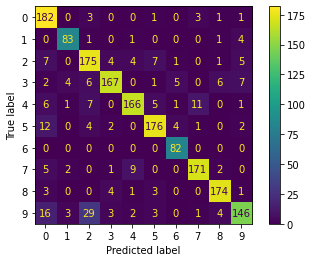

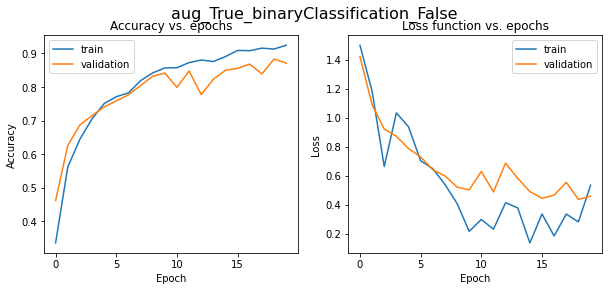

In [ ]:
trained_net, loss_tr, loss_val, accuracy_val, accuracy_train = run_multiOptions_training_Class(parent_dir, class_ord, transform=True, binary=False)

Now we explore the performences on the test dataset 

Validate that the model is on the GPU: True
Succefull create *test* dataset with 1747 items


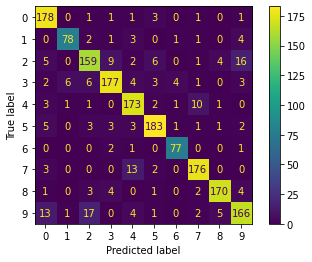

                  precision    recall  f1-score   support

 air_conditioner       0.85      0.96      0.90       186
        car_horn       0.91      0.87      0.89        90
children_playing       0.83      0.79      0.81       202
        dog_bark       0.90      0.86      0.88       206
        drilling       0.85      0.90      0.87       192
   engine_idling       0.91      0.91      0.91       202
        gun_shot       0.92      0.95      0.93        81
      jackhammer       0.90      0.91      0.90       194
           siren       0.94      0.92      0.93       185
    street_music       0.84      0.79      0.82       209

        accuracy                           0.88      1747
       macro avg       0.88      0.88      0.88      1747
    weighted avg       0.88      0.88      0.88      1747



In [ ]:
evaluate_on_test_data(None, parent_dir, class_ord, transform=True, binary=False)

As we can see, for the Multi-Class + Augmentation we got:

-Training set accuracy:0.925

-Validation set accuracy:0.871  

-Test set accuracy:0.88

(we improved performance a bit)

And specifically, for gun_shot we got f1-score: 0.93

from the color matrix (for the performances on the test dataset) above, we can see that for "True label" num.6 (gunshot), we improved results in terms of identification, and we were less wrong in predicting. (from the color matrix (for the performances on the training dataset) we can see that there is no mistake at all in the "Predict label".

# **Binary Classification**

Now, we perform binary classification. Meaning we classify each sample to one of gun shot or non-gun shot signal. Notice that we use binary cross-entropy and we don't perform data augmentation at first.

Validate that the model is on the GPU: True
Succefull create *train* dataset with 5238 items with binary mode
Succefull create *valid* dataset with 1747 items with binary mode


  0%|          | 0/20 [00:00<?, ?it/s]

We didn't improve 5 epoch, so finish the training... best epoch and accuracy are 9 and 0.9965655207633972, respectively.


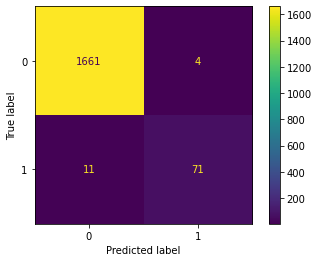

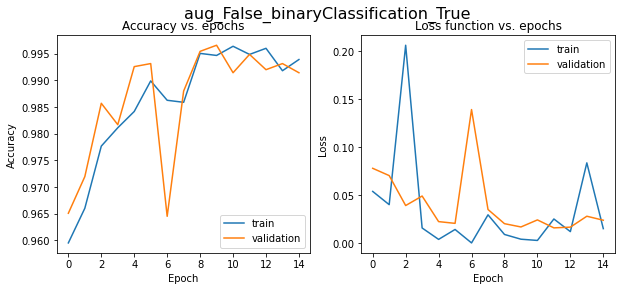

In [ ]:
trained_net, loss_tr, loss_val, accuracy_val, accuracy_train = run_multiOptions_training_Class(parent_dir, class_ord, transform=False, binary=True)

Evaluation on the test dataset

Validate that the model is on the GPU: True
Succefull create *test* dataset with 1747 items with binary mode


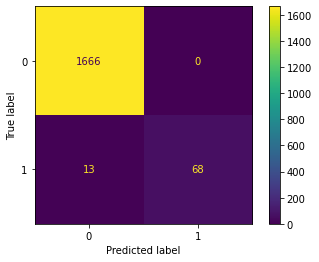

['not_gun_shot', 'gun_shot']
              precision    recall  f1-score   support

not_gun_shot       0.99      1.00      1.00      1666
    gun_shot       1.00      0.84      0.91        81

    accuracy                           0.99      1747
   macro avg       1.00      0.92      0.95      1747
weighted avg       0.99      0.99      0.99      1747



In [ ]:
evaluate_on_test_data(None, parent_dir, class_ord, transform=False, binary=True)

As we can see, for the Binary Classification we got:

-Training set accuracy:0.994

-Validation set accuracy:0.991 
 
-Test set accuracy:0.99

From the color matrix (for the performances on the test dataset) above, we can see that for "True label" num.0 (non-gunshot), there is no mistake at all in "Predicted label" and for "True label" num.1 (gunshot), there are 13 Incorrect "Predicted label". We will try to improve the results in the next model.

# **Binary Classification + Augmentation**

Validate that the model is on the GPU: True
Succefull create *train* dataset with 5238 items with binary mode
Succefull create *valid* dataset with 1747 items with binary mode


  0%|          | 0/20 [00:00<?, ?it/s]

We didn't improve 5 epoch, so finish the training... best epoch and accuracy are 14 and 0.9977103471755981, respectively.


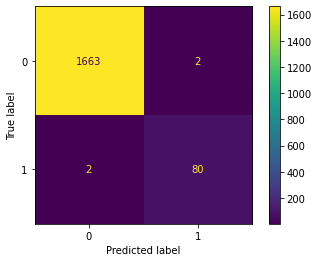

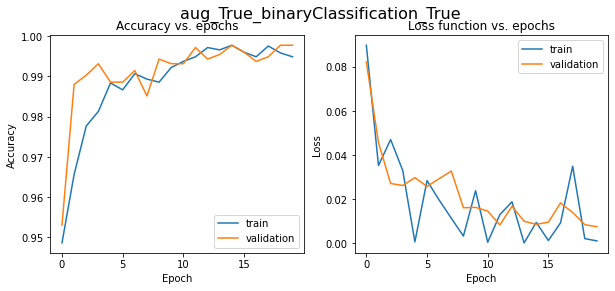

In [ ]:
trained_net, loss_tr, loss_val, accuracy_val, accuracy_train = run_multiOptions_training_Class(parent_dir, class_ord, transform=True, binary=True)

Evaluation on the test dataset

Validate that the model is on the GPU: True
Succefull create *test* dataset with 1747 items with binary mode


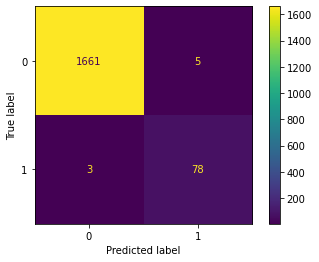

['not_gun_shot', 'gun_shot']
              precision    recall  f1-score   support

not_gun_shot       1.00      1.00      1.00      1666
    gun_shot       0.94      0.96      0.95        81

    accuracy                           1.00      1747
   macro avg       0.97      0.98      0.97      1747
weighted avg       1.00      1.00      1.00      1747



In [ ]:
evaluate_on_test_data(None, parent_dir, class_ord, transform=True, binary=True)

We improved performance! As we can see, for the Binary Classification+ Augmentation we got:

-Training set accuracy:0.995

-Validation set accuracy:0.998 
 
-Test set accuracy:1.00

From the color matrix (for the performances on the test dataset) above, we can see that for "True label" num.1 (gunshot), there are 3 mistakes in "Predicted label". Notice that we improved the "recall", in this model we got 0.96 (the True positive from the predicted results).

# Blending the sounds

In [ ]:
class CustomSoundDataset(Dataset):
    def __init__(self, parent_dir, root_dir, data_mode='train',
                 class_ord=None, p_blending=0.3, transform=None, binary=False, required_shape=(64,64)):
      
        curr_path = os.path.join(parent_dir, f'UrbanSound8K_{data_mode}.csv')
        df_all = pd.read_csv(curr_path)
        self.required_shape = required_shape
        self.data_mode = data_mode
        self.df_info = df_all

        self.root_dir = root_dir
        self.n_classes = 2 if binary else 10

        self.x_train = pd.read_csv(os.path.join(parent_dir, f'UrbanSound8K_train.csv'))

        self.binary = binary
        
        self.class_ord = class_ord if binary else None
        
        self.p_blending = p_blending

        self.data_mode = data_mode
        self.transform = transform
        self.max_len = 89009
        if self.max_len is None:
            self.set_max_len()
        
        str_binary = 'binary' if binary else 'multi class'
        print(f'Succefull create *{data_mode}* dataset with {self.__len__()} items with {str_binary} mode')

    def __len__(self):
        return len(self.df_info)

    def set_max_len(self):
        train_data = self.x_train
        self.all_lengths = []
        for ind in range(train_data.shape[0]):
            # try:
            row = train_data.iloc[ind, :]
            file_path = os.path.join(self.root_dir, 'fold{}'.format(row.fold), row.slice_file_name)
            if os.path.isfile(file_path):
                x, sr = librosa.load(file_path, res_type='kaiser_fast')
            else:
                print(f"index {ind}: file '{file_path}' does not exist!")
            self.all_lengths.append(x.shape[0])

        self.max_len = max(self.all_lengths)
        print(f"the max length of audio file in the training data is: {self.max_len}")

    def blending(self, x, label):
        n_sig_blend = np.random.randint(1, 4, size=1)[0] + 1
        label_vec = np.zeros(self.n_classes)
        label_vec[label] = 1.0  #/ n_sig_blend # todo: change to 1
        signal = x / n_sig_blend
        which_class_blend = np.random.randint(self.n_classes, size=n_sig_blend)
        for curr_class in which_class_blend:
            label_vec[curr_class] = 1.0 #/ n_sig_blend # todo: change to 1
            mask = self.df_info.loc[:, "classID"].values == curr_class
            row = self.df_info.loc[mask, :].sample()
            x_curr, sr, curr_label = self.read_signal_by_row(row)
            assert curr_label == curr_class
            signal += x_curr / n_sig_blend
        return signal, label_vec

    def one_hot(self, label):
        return np.eye(self.n_classes)[label]

    def read_signal_by_row(self, row):
        n_fold = row.fold
        if not isinstance(n_fold, np.int64):
            n_fold = n_fold.values[0]
        f_name = row.slice_file_name
        if not isinstance(f_name, str):
            f_name = f_name.values[0]
            # print(f" File name is not str {f_name}, changed to string")
        file_path = os.path.join(self.root_dir, 'fold{}'.format(n_fold), f_name)
        x, sr = librosa.load(file_path, res_type='kaiser_fast')

        label = row.classID
        if not isinstance(label, np.int64):
            label = label.values[0]
        curr_len = x.shape[0]
        if curr_len > self.max_len:
            x = x[:self.max_len]
        elif curr_len < self.max_len:
            x_temp = np.zeros(self.max_len)
            x_temp[:curr_len] = x
            x = x_temp
        return x, sr, label

    def sig2spec(self, signal, sr):
        stft = np.abs(librosa.stft(signal.squeeze())) ** 2
        spec = librosa.feature.melspectrogram(S=stft, sr=sr)
        spec_dB = librosa.power_to_db(spec, ref=np.max)
        down_spec = cv2.resize(spec_dB, dsize=self.required_shape, interpolation=cv2.INTER_LINEAR)
        return down_spec

    def __getitem__(self, idx):
        row = self.df_info.iloc[idx, :]
        x, sr, label = self.read_signal_by_row(row)
        if self.binary:
            label = 1 if self.class_ord[label] == 'gun_shot' else 0
        if self.data_mode == 'train' and np.random.binomial(1, self.p_blending, 1)[0]:
            x, label_vec = self.blending(x, label)
        else:
            label_vec = self.one_hot(label)

        image = self.sig2spec(x, sr)
        image = torch.from_numpy(image).float()
        label_vec = torch.from_numpy(label_vec).float()
        if self.transform and self.data_mode == 'train':
            image = self.transform(image)

        return image[None], label_vec

In [ ]:
def run_mix_multiOptions_training_Class(parent_dir, root_dir, class_ord, transform, binary=False,mix=True, epochs=20):
  exp_name = f'mixed_aug_{transform}_binaryClassification_{binary}'
  save_path = os.path.join(parent_dir, f'best_model_{exp_name}.pt')
  
  criterion = nn.BCEWithLogitsLoss()
  
  output_size = 1 if binary else 10 # parent_dir, root_dir
  model = CNN_Model(in_channels=1, filters=[16, 16, 16, 32], kernel_size=3, pooling=2, fc_sizes=[512, 128], output_size=output_size)
  model = model.to(device)
  print(f"Validate that the model is on the GPU: {next(model.parameters()).is_cuda}")
  optimizer = torch.optim.Adam(model.parameters())
  train_dataset = CustomSoundDataset(parent_dir=parent_dir, root_dir=root_dir, data_mode='train', class_ord=class_ord, transform=transform, binary=binary)
  valid_dataset = CustomSoundDataset(parent_dir=parent_dir, root_dir=root_dir, data_mode='valid', class_ord=class_ord, transform=transform, binary=binary)
  trained_net, loss_tr, loss_val, accuracy_train, accuracy_val = training_func(optimizer, criterion, model, train_dataset, valid_dataset, 
                                                                               save_path, epochs, binary=binary, mix=mix)
  plot_graphs(accuracy_train, accuracy_val, loss_tr, loss_val, title=exp_name)
  return trained_net, loss_tr, loss_val, accuracy_val, accuracy_train


def evaluate_on_test_data(trained_net, parent_dir, root_dir, class_ord, transform, binary, mix=True):
  exp_name = f'aug_{transform}_binaryClassification_{binary}'
  save_path = os.path.join(parent_dir, f'best_model_aug_{transform}_binaryClassification_{binary}.pt')

  criterion = nn.BCELoss() if binary else nn.CrossEntropyLoss()  

  if trained_net is None:
    output_size = 1 if binary else 10
    model = CNN_Model(in_channels=1, filters=[16, 16, 16, 32], kernel_size=3, pooling=2, fc_sizes=[512, 128], output_size=output_size)
    if os.path.isfile(save_path):
      model.load_state_dict(torch.load(save_path))
      trained_net = model
  trained_net = trained_net.to(device)
  trained_net.eval()
  print(f"Validate that the model is on the GPU: {next(trained_net.parameters()).is_cuda}")
  test_dataset = CustomSoundDataset(parent_dir=parent_dir,root_dir=root_dir, data_mode='test', class_ord=class_ord, transform=transform, binary=binary)
  test_dataloader = DataLoader(test_dataset, batch_size=64, num_workers=2)
  loss_mean, acc, all_pred, all_labels = eval_validation(test_dataloader, trained_net, criterion, binary, mix=mix)
  all_labels_np = torch.cat(all_labels).cpu().numpy()
  all_pred_np = torch.cat(all_pred).cpu().numpy()
  plot_con_mat(all_labels_np, all_pred_np)
  target_names=list(class_ord.values()) if not binary else ['not_gun_shot', 'gun_shot']
  print(target_names)
  print(classification_report(all_labels_np, all_pred_np, target_names=target_names))

In [ ]:
root_dir=os.path.join(base_path, 'data/UrbanSound8K/audio')

trained_net, loss_tr, loss_val, accuracy_val, accuracy_train = run_mix_multiOptions_training_Class(base_path, root_dir, class_ord, transform=False, binary=False)

Validate that the model is on the GPU: True
Succefull create *train* dataset with 5238 items with multi class mode
Succefull create *valid* dataset with 1747 items with multi class mode


  0%|          | 0/20 [00:00<?, ?it/s]

ValueError: ignored

In [ ]:
evaluate_on_test_data(None, parent_dir, root_dir, class_ord, transform=True, binary=True, mix=True)

Validate that the model is on the GPU: True


FileNotFoundError: ignored

# **Logistic Regression Classifier and Decision  Tree Classifier**

* Logistic Regression - a ‘Statistical Learning’ technique categorized in ‘Supervised’ Machine Learning (ML) methods dedicated to ‘Classification’ tasks.

* Decision Tree Classifier -   decision tree. Each node in the tree specifies a test on an attribute, each branch descending from that node corresponds to one of the possible values for that attribute

In [ ]:
data_mode = 'train'
curr_path = os.path.join(parent_dir, data_mode, 'spectrogram_images.csv')
df_train = pd.read_csv(curr_path)
all_spec_train = []
for idx in tqdm(range(df_train.shape[0])):
  img_path = os.path.join(df_train.iloc[idx, 0])
  image = np.load(img_path, allow_pickle=True)
  all_spec_train.append(image.flatten()[None])

np_spec_train = np.concatenate(all_spec_train, axis=0)
np_lbls_train = df_train.loc[:,'class'].values
print(f"data shape {np_spec_train.shape}, labels shape {np_lbls_train.shape}")

  0%|          | 0/5238 [00:00<?, ?it/s]

data shape (5238, 4096), labels shape (5238,)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
x_train = scaler.fit_transform(np_spec_train)

#logistic regression
Logistic_Reg_classifier=LogisticRegression(random_state=seed, solver='saga', max_iter=20,)
Logistic_Reg_classifier.fit(x_train, np_lbls_train)

#Decision Tree Classifier
DesicionTree_classifier=DecisionTreeClassifier(random_state=seed)
DesicionTree_classifier.fit(x_train, np_lbls_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


DecisionTreeClassifier(random_state=123)

# **Results for the logistic regression classifier on the validation and test set**

In [ ]:
for data_mode in ['valid', 'test']: 
  curr_path = os.path.join(parent_dir, data_mode, 'spectrogram_images.csv')
  df_curr = pd.read_csv(curr_path)
  all_spec_valid = []
  for idx in tqdm(range(df_curr.shape[0])):
    img_path = os.path.join(df_curr.iloc[idx, 0])
    image = np.load(img_path, allow_pickle=True)
    all_spec_valid.append(image.flatten()[None])

  np_spec_curr = np.concatenate(all_spec_valid, axis=0)
  np_lbls_curr = df_curr.loc[:,'class'].values
  print(f"data shape {np_spec_curr.shape}, labels shape {np_lbls_curr.shape}")

  x_curr=scaler.transform(np_spec_curr)
  y_curr_pred=Logistic_Reg_classifier.predict(x_curr)
  target_names=list(class_ord.values())
  print(f"{data_mode} results:")
  print(classification_report(np_lbls_curr, y_curr_pred, target_names=target_names))

  0%|          | 0/1747 [00:00<?, ?it/s]

data shape (1747, 4096), labels shape (1747,)
valid results:
                  precision    recall  f1-score   support

 air_conditioner       0.45      0.63      0.52       191
        car_horn       0.72      0.70      0.71        90
children_playing       0.49      0.48      0.48       204
        dog_bark       0.71      0.58      0.64       198
        drilling       0.65      0.61      0.63       198
   engine_idling       0.65      0.51      0.57       201
        gun_shot       0.82      0.72      0.77        82
      jackhammer       0.52      0.64      0.57       190
           siren       0.75      0.76      0.76       186
    street_music       0.56      0.51      0.54       207

        accuracy                           0.60      1747
       macro avg       0.63      0.61      0.62      1747
    weighted avg       0.61      0.60      0.60      1747



  0%|          | 0/1747 [00:00<?, ?it/s]

data shape (1747, 4096), labels shape (1747,)
test results:
                  precision    recall  f1-score   support

 air_conditioner       0.39      0.56      0.46       186
        car_horn       0.74      0.62      0.67        90
children_playing       0.46      0.46      0.46       202
        dog_bark       0.69      0.56      0.62       206
        drilling       0.58      0.63      0.61       192
   engine_idling       0.63      0.44      0.52       202
        gun_shot       0.71      0.77      0.74        81
      jackhammer       0.54      0.67      0.60       194
           siren       0.84      0.78      0.81       185
    street_music       0.55      0.49      0.52       209

        accuracy                           0.58      1747
       macro avg       0.61      0.60      0.60      1747
    weighted avg       0.60      0.58      0.58      1747



As we can see. for the logistic regression classifier on the validation we got: 

-Validation set accuracy:0.6  
-Test set accuracy:0.58

And specifically, for gun_shot:

-Validation set f1-score:0.77  
-Test set f1-score:0.74 

Notice that we got much lower results compared to what we got for the models with the CNN. 

# **Results for the Decision tree classifier on the validation and test set**

In [ ]:
for data_mode in ['valid', 'test']: 
  curr_path = os.path.join(parent_dir, data_mode, 'spectrogram_images.csv')
  df_curr = pd.read_csv(curr_path)
  all_spec_valid = []
  for idx in tqdm(range(df_curr.shape[0])):
    img_path = os.path.join(df_curr.iloc[idx, 0])
    image = np.load(img_path, allow_pickle=True)
    all_spec_valid.append(image.flatten()[None])

  np_spec_curr = np.concatenate(all_spec_valid, axis=0)
  np_lbls_curr = df_curr.loc[:,'class'].values
  print(f"data shape {np_spec_curr.shape}, labels shape {np_lbls_curr.shape}")

  x_curr=scaler.transform(np_spec_curr)
  y_curr_pred=DesicionTree_classifier.predict(x_curr)
  target_names=list(class_ord.values())
  print(f"{data_mode} results:")
  print(classification_report(np_lbls_curr, y_curr_pred, target_names=target_names))

  0%|          | 0/1747 [00:00<?, ?it/s]

data shape (1747, 4096), labels shape (1747,)
valid results:
                  precision    recall  f1-score   support

 air_conditioner       0.48      0.57      0.52       191
        car_horn       0.44      0.36      0.39        90
children_playing       0.26      0.25      0.25       204
        dog_bark       0.60      0.61      0.60       198
        drilling       0.59      0.58      0.59       198
   engine_idling       0.58      0.61      0.59       201
        gun_shot       0.81      0.71      0.75        82
      jackhammer       0.59      0.61      0.60       190
           siren       0.50      0.52      0.51       186
    street_music       0.35      0.31      0.33       207

        accuracy                           0.51      1747
       macro avg       0.52      0.51      0.51      1747
    weighted avg       0.50      0.51      0.50      1747



  0%|          | 0/1747 [00:00<?, ?it/s]

data shape (1747, 4096), labels shape (1747,)
test results:
                  precision    recall  f1-score   support

 air_conditioner       0.51      0.56      0.54       186
        car_horn       0.48      0.47      0.47        90
children_playing       0.34      0.35      0.35       202
        dog_bark       0.62      0.51      0.56       206
        drilling       0.59      0.61      0.60       192
   engine_idling       0.58      0.58      0.58       202
        gun_shot       0.77      0.80      0.79        81
      jackhammer       0.62      0.65      0.63       194
           siren       0.53      0.50      0.51       185
    street_music       0.40      0.41      0.40       209

        accuracy                           0.53      1747
       macro avg       0.54      0.55      0.54      1747
    weighted avg       0.53      0.53      0.53      1747



As we can see, for the Decision tree classifier we got:

-Validation set accuracy:0.51  
-Test set accuracy:0.53

And specifically, for gun_shot:

-Validation f1-score:0.75 
-Test set f1-score:0.79

Notice that we got much lower results compared to what we got for the models with the CNN.

# **Result analysis**

name | results
--- | ---
`**Naive model**` | **Test set accuracy:~0**
`**Multi label classification**` | **Test set accuracy: 0.86 , and specific to gun_shot - Test set f1-score: 0.92**
`**Multi Class + Augmentation**` | **Test set accuracy:0.88, and specific to gun_shot - Test set f1-score: 0.93**
`**Binary Classification**` | **Test set accuracy:0.99**
`**Binary Classification + Augmentation**` | **Test set accuracy:1.00**
`**Blending the sounds**` | **Test set accuracy:**
`**Logistic Regression Classifier**` | **Test set accuracy:0.58 and specific to gun_shot -Test set  f1-score: 0.74**
`**Decision Tree Classifier**` | **Test set accuracy:0.53 and specific to gun_shot- Test set  f1-score:0.79**





We note that the highest accuracy we got for the method: Binary Classification + Augmentation.

In addition, notice that we got very high accuracy for the methods we worked with CNN compared to the accuracy we got for the non-deep learning methods (Logistic Regression Classifier, Decision Tree Classifier). While we have not reached results that are 100% successful, You can see that we have achieved impressive and high results!

# **Conclusion**

The data set itself is not very user-friendly - the samplings
have various lengths and some files are even damaged. However, we were able to
bypass the problems using feature extraction and some manual fixing (we used zero padding to avoid the various length problem).

The project turned out to be successful, even though we were not able to recognize all the samplings 100%. The obtained accuracy is higher than what we expected, and we are happy with that.

Convolutional neural networks (CNN), which are designed specifically for object recognition in images, can be successfully trained to classify spectral images of environmental sounds, as we have seen in this project. We dealt with an unbalanced dataset, which made it difficult for us, but we think we dealt with it very well.

While working on the project, we learned a lot about signal processing for sounds, understanding the uniqueness of the gunshot sound signal.

We note that we got the best results for the Binary Classification with the Augmentation.

# **References**

[1] Pierce, A.D.: ‘Statistical theory of atmospheric turbulance effects on sonic boom rise times’,J. Acoust. Soc. Am., 1971,49, (3B), pp. 906–924.

[2] Maher,  R.C.:  ‘Modeling  and  signal  processing  of  acoustic  gunshot recordings’.  Proc.  IEEE  Signal  Processing  Society  12th  DSP  Workshop September 2006, vol. 59, pp. 257–261

[3] Bergler, C., Schröter, H., Cheng, R.X. et al. ‘ORCA-SPOT: An Automatic Killer Whale Sound Detection Toolkit Using Deep Learning’. Sci Rep 9, 10997 (2019). https://doi.org/10.1038/s41598-019-47335-w

[4] UrbanSound8K dataset -  https://urbansounddataset.weebly.com/urbansound8k.html

[5] Convolutional Neural Networks (CNN) - https://cs231n.github.io/convolutional-networks/

[6] precision and recall -  https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

**To PDF**

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 c

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "./drive/My Drive/Intro_to_Deep_Learning/project//final_notebook.ipynb" ./

In [ ]:
!jupyter nbconvert --to PDF "final_notebook.ipynb"

[NbConvertApp] Converting notebook final_notebook.ipynb to PDF
[NbConvertApp] ERROR | Notebook JSON is invalid: Additional properties are not allowed (u'metadata' was unexpected)

Failed validating u'additionalProperties' in stream:

On instance[u'cells'][82][u'outputs'][0]:
{u'metadata': {u'tags': None},
 u'name': u'stdout',
 u'output_type': u'stream',
 u'text': u'Validate that the model is on the GPU: True\nSuccefull create *train* dataset with 5238 items with multi class mode\nSuccefull create *valid* dataset with 1747 items with multi class mode\n'}
[NbConvertApp] Support files will be in final_notebook_files/
[NbConvertApp] Making directory ./final_notebook_files
[NbConvertApp] Making directory ./final_notebook_files
[NbConvertApp] Making directory ./final_notebook_files
[NbConvertApp] Making directory ./final_notebook_files
[NbConvertApp] Making directory ./final_notebook_files
[NbConvertApp] Making directory ./final_notebook_files
[NbConvertApp] Making directory ./final_notebook